In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_dir = r"dataset/ImageEmotion (85-15)/train"
test_dir = r"dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range= 0.1,
                                   height_shift_range= 0.05,
                                  rescale= 1./255,
                                  preprocess_function= preprocess_fn)

test_datagen = ImageDataGenerator(rescale= 1./255,
                                 preprocess_function= preprocess_fn)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

In [8]:
#loading features required
train_CNNfeatures = np.load(r'FeatureFiles/train_MobileNetfeatures_(7,7,1024).npy')
print('Loaded train CNN features')
test_CNNfeatures = np.load(r'FeatureFiles/test_MobileNetfeatures_(7,7,1024).npy')
print('Loaded test CNN features')
train_lowfeatures = np.load(r'FeatureFiles/train_lowfeatures.npy')
print('Loaded train low features')
test_lowfeatures = np.load(r'FeatureFiles/test_lowfeatures.npy')
print('Loaded test low features')
train_mainobject = np.load(r'FeatureFiles/train_mainobject_data.npy')
print('Loaded train main object data')
test_mainobject = np.load(r'FeatureFiles/test_mainobject_data.npy')
print('Loaded test main object data')
train_semantic = np.load(r'FeatureFiles/train_semanticfeatures.npy')
print('Loaded train semantic features')
test_semantic = np.load(r'FeatureFiles/test_semantcifeatures.npy')
print('Loaded test semantic features')

train_labels = np.load(r'FeatureFiles/train_labels.npy')
print('Loaded train labels')
test_labels = np.load(r'FeatureFiles/test_labels.npy')
print('Loaded test labels')

Loaded train low features
Loaded test low features
Loaded train labels
Loaded test labels


In [ ]:
#taking GAP of CNN features
train_CNNfeatures_GAP = tf.keras.layers.GlobalAveragePooling2D()(train_CNNfeatures)
test_CNNfeatures_GAP = tf.keras.layers.GlobalAveragePooling2D()(test_CNNfeatures)

In [1]:
#Concatinating all domain-respective features
train_features = tf.concat([train_semantic, train_mainobject, train_CNNfeatures_GAP, train_lowfeatures], axis=1)
test_features = tf.concat([test_semantic, test_mainobject, test_CNNfeatures_GAP, test_lowfeatures], axis=1)

NameError: name 'tf' is not defined

In [5]:
def classifier(inputs):
#     x = tf.keras.layers.Dense(1500, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.001))(features)
#     x = tf.keras.layers.Dense(500, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
#     x = tf.keras.layers.Dense(100, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              #kernel_regularizer= tf.keras.regularizers.l2(0.01),
                              name='classification')(x)
    
    return x
        
def final_model(inputs):
    classification_output = classifier(inputs)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(2189,))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs= inputs, outputs= classification_output)
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [7]:
model = define_compile_model()

model.summary()

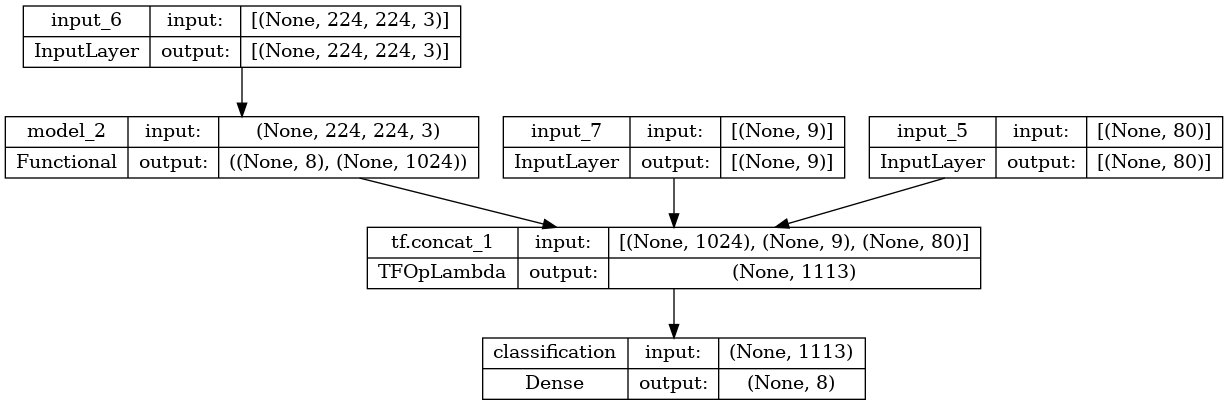

In [8]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [9]:
checkpoint = ModelCheckpoint('MobileNet_CNN+Sem+LF+MainObject-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, 
                        monitor='val_accuracy',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [10]:
history = model.fit(train_features, train_labels,
                    batch_size = BATCH_SIZE,
                    epochs= 500,
                    validation_data = (test_features, test_labels),
                    validation_batch_size= BATH_SIZE,
                    callbacks= [checkpoint]
                    )

history = pd.DataFrame(history.history)

Epoch 1/200
145/145 [==============================] - ETA: 0s - loss: 20.7189 - accuracy: 0.1944
Epoch 1: accuracy improved from -inf to 0.19441, saving model to Idea1_1_MobileNet-001-0.194407.h5
145/145 [==============================] - 336s 2s/step - loss: 20.7189 - accuracy: 0.1944
Epoch 2/200
145/145 [==============================] - ETA: 0s - loss: 12.6889 - accuracy: 0.2962
Epoch 2: accuracy improved from 0.19441 to 0.29624, saving model to Idea1_1_MobileNet-002-0.296244.h5
145/145 [==============================] - 332s 2s/step - loss: 12.6889 - accuracy: 0.2962
Epoch 3/200
145/145 [==============================] - ETA: 0s - loss: 9.4166 - accuracy: 0.3543
Epoch 3: accuracy improved from 0.29624 to 0.35428, saving model to Idea1_1_MobileNet-003-0.354276.h5
145/145 [==============================] - 332s 2s/step - loss: 9.4166 - accuracy: 0.3543
Epoch 4/200
145/145 [==============================] - ETA: 0s - loss: 7.3618 - accuracy: 0.4049
Epoch 4: accuracy improved from 0.3

KeyboardInterrupt: 